In [ ]:
#Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
import math
import statistics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif, SelectKBest

# Playground Area:

# Task 0: Explore The Data and Cleaning

+++ Cropping down the area to only include lesion to uptimize runtime of code. +++

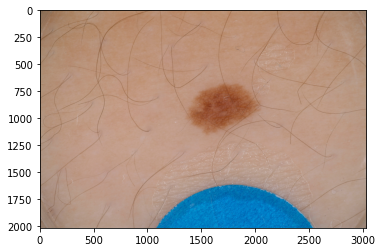

In [ ]:
# Load in the image and the segmentation
path=os.getcwd()#'something/somthingelse/fyp2021/notebooks'
path=path[:-9]+'data/example_image/'#something/somthingelse/fyp2021/data/example_image/'

the_image = "ISIC_0001769" # This is the image to be used in the rest of the code.

path=path+the_image+".jpg"
im = plt.imread(path)
plt.imshow(im)


path=os.getcwd()#'something/somthingelse/fyp2021/notebooks'
path=path[:-9]+'data/example_segmentation/'#something/somthingelse/fyp2021/data/example_image/'
path=path+the_image+'_segmentation.png' # Takes the_image name + _segmentation.png to get the right segmentation file.
imseg=plt.imread(path)

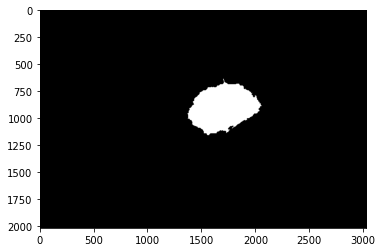

In [ ]:
plt.imshow(imseg,cmap='gray')

test = imseg[:,1500]

(2016, 3024, 3)
uint8


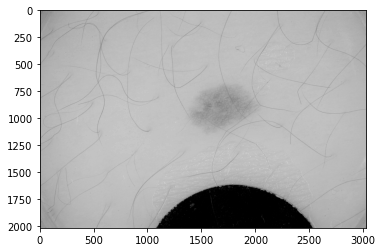

In [ ]:
# Shape and dimension of the image
print(im.shape)
print(im.dtype)

# Get a single RGB value from the blue circle (marker used by dermatologist)
# print(im[2000,2000,:])

# Show only the red channel
plt.imshow(im[:,:,0],cmap='gray')

In [ ]:
# # Finding maximum and minimum height and width of the lesion.
# heights=[]
# widths=[]
# # The range is chosen by visual inspection.
# for i in range(len(imseg)):
#     test=imseg[:,i]
#     test=list(test)
#     white1=test.count(1)
#     if white1!=0:
#         heights.append(white1)
# print('The max height is:',max(heights))
# print('The min height is:',min(heights))

# print()

# # The range is chosen by visual inspection.
# for i in range(len(imseg)):
#     test=imseg[i]
#     test=list(test)
#     white=test.count(1)
#     if white!=0:
#         widths.append(white)
# print('The max width is:',max(widths))
# print('The min width is:',min(widths)) 

## Cutting down the image to only the relevant area

In [ ]:
minrow=-1
for i in imseg:
    minrow+=1
    if 1 in i:
        break
mincol=-1
for i in imseg.T:
    mincol+=1
    if 1 in i:
        break
height,width=imseg.shape
maxrow=-1
for i in np.flip(imseg,axis=0):
    maxrow+=1
    if 1 in i:
        break
maxcol=-1
for i in np.flip(imseg,axis=1).T:
    maxcol+=1
    if 1 in i:
        break
maxrow=height-maxrow-1
maxcol=width-maxcol-1
#cutting down the image segmentation
imseg=imseg[minrow:maxrow,mincol:maxcol]
#cutting down all the channels individually and stacking them to cut down image
red=im[minrow:maxrow,mincol:maxcol,0]
green=im[minrow:maxrow,mincol:maxcol,1]
blue=im[minrow:maxrow,mincol:maxcol,2]
im=np.dstack([red,green,blue])

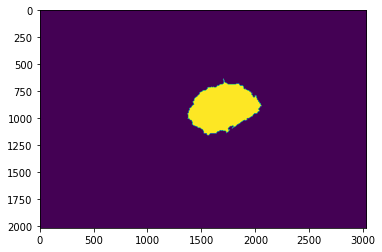

In [ ]:
plt.imshow(imseg)

In [ ]:
# Calculating the perimeter and the area of the lesion, taking the picture as an arrray.
def getoutline(imseg):
    minrow=-1
    for i in imseg:
        minrow+=1
        if 1 in i:
            break
    mincol=-1
    for i in imseg.T:
        mincol+=1
        if 1 in i:
            break
    height,width=imseg.shape
    maxrow=-1
    for i in np.flip(imseg,axis=0):
        maxrow+=1
        if 1 in i:
            break
    maxcol=-1
    for i in np.flip(imseg,axis=1).T:
        maxcol+=1
        if 1 in i:
            break
    maxrow=height-maxrow
    maxcol=width-maxcol
    #cutting down the image segmentation
    imseg=imseg[minrow:maxrow,mincol:maxcol]
    outline=[]
    row=0
    prev=0
    for i in imseg:
        column=0
        prev=0
        i=list(i)
        if 1 in i:
            for j in i:
                if j != prev and prev==0 and [row,column] not in outline:
                    outline.append([row,column])
                elif j!= prev and prev==1 and [row,column-1] not in outline:
                    outline.append([row,column-1])
                prev=j
                column+=1
        row+=1
    column=0
    for i in imseg.T:
        row=0
        prev=0
        i=list(i)
        if 1 in i:
            for j in i:
                # print(j)
                if j==1 and prev==0 and [row,column] not in outline:
                    outline.append([row,column])
                elif j==0 and prev==1 and [row-1,column] not in outline:
                    outline.append([row-1,column])
                prev=j
                row+=1
        column+=1
    return outline
outline=getoutline(imseg)
print('Perimeter is',len(outline),'pixels long')

print('The area is',sum(sum(imseg)),'pixels')



Perimeter is 3149 pixels long
The area is 470897.0 pixels


# Task 1: Implement Two Features

## Feature 1: Asymmetry

How this super awesome symmetry check works:

1) Split the outline of the shape in the middle assigning one or two middle columns depending on if the horizontal length is even or odd. Also assigns a middle row roughly.

2) Start with the leftmost column of pixels and get the distance to a fixed \[middlecol,middlerow] point, basically the centre, for each pixel in this column.

3) Sum all of these distances.

4) Then on the right side, it looks at which row the pixel in the left was in the related column, finds the nearest one here and calculates the distance to that same fixed point.

5) Then the result is given as the difference of both sums

6) profit

In [ ]:
path=os.getcwd()#'something/somthingelse/fyp2021/notebooks'
path=path[:-9]+'data/example_segmentation/'#something/somthingelse/fyp2021/data/example_image/'
path=path+relevantimages[1]+'_segmentation.png' # Takes the_image name + _segmentation.png to get the right segmentation file.
imseg=plt.imread(path)

In [ ]:
# Getting a symmetry value

def symcheck(outline):
    left={}
    right={}
    outlineset=set([x[0] for x in outline])#making a set with all column numbers in the outline
    rowset=set([x[1] for x in outline])#making a set with all row numbers in the outline
    mincol=min(outlineset)
    maxcol=max(outlineset)
    minrow=min(rowset)
    maxrow=max(rowset)
    middlerow=round((maxrow+minrow)/2)
    #checking if the shape is even or odd, assigning a middle column based on that
    if (maxcol+mincol) % 2!=1:
        middlecol=int((maxcol+mincol)/2-0.5)
        for i in range(mincol,middlecol):#making dictinaries for both sides where entries are {column:[rows with pixels]}
            left[i]=[]
        for i in range(middlecol+1,maxcol+1):
            right[i]=[]
        for i in outline:
            if i[0]<middlecol:
                left[i[0]].append(i[1])
            elif i[0]>middlecol:
                right[i[0]].append(i[1])
        even=False
    else:#same thing but for even values of width
        middlecol=[int((maxcol+mincol)/2),int((maxcol+mincol)/2+1)]
        for i in range(mincol,middlecol[0]):
            left[i]=[]
        for i in range(middlecol[1]+1,maxcol+1):
            right[i]=[]
        for i in outline:
            if i[0]<middlecol[0]:
                left[i[0]].append(i[1])
            elif i[0]>middlecol[1]:
                right[i[0]].append(i[1])
        even=True
    counter=0
    leftcounter=mincol#setting the start values for both 
    rightcounter=maxcol
    leftdistance=0
    rightdistance=0
    prevclose=middlerow
    for i in range(len(left)):
        for j in left[leftcounter]:
            curlist=right[rightcounter]#finding corresponding list on the other side
            distancelist=[abs(x-j) for x in curlist]
            if distancelist==[]:    
                closest=prevclose
            else:
                closest=curlist[distancelist.index(min(distancelist))]#getting the closest pixel
            if even==True:
                leftdistance=leftdistance+math.sqrt((abs(j-middlerow)**2)+(abs(leftcounter-middlecol[0])**2))
                rightdistance=rightdistance+math.sqrt((abs(rightcounter-middlecol[1])**2)+(abs(closest-middlerow)**2))
            else:
                leftdistance=leftdistance+math.sqrt((abs(j-middlerow)**2)+(abs(leftcounter-middlecol)**2))
                rightdistance=rightdistance+math.sqrt((abs(rightcounter-middlecol)**2)+(abs(closest-middlerow)**2))
            prevclose=closest
        leftcounter+=1
        rightcounter-=1
    print('The vertical symmetry value for this shape is:',abs(rightdistance-leftdistance))
    return abs(rightdistance-leftdistance)
symcheck(rotate(getoutline(imseg)))

The vertical symmetry value for this shape is: 2983.104430577514


2983.104430577514

130 493
-0.25782286637218144


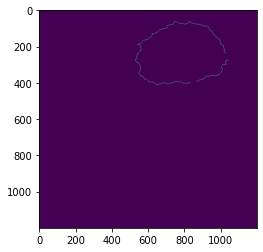

In [ ]:
matrix=np.zeros([1200,1200])
for i in rotate(getoutline(imseg)):
    matrix[i[0],i[1]]=1
plt.imshow(matrix)
# matrix=np.zeros([2000,2000])
# for i in getoutline(imseg):
#     matrix[i[0],i[1]]=1
# plt.imshow(matrix)

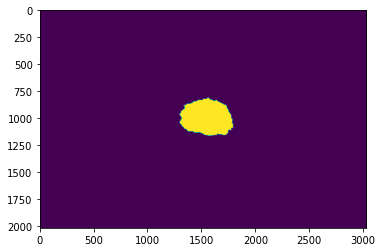

In [ ]:
plt.imshow(imseg)

In [ ]:
#diameter finding
def getdiameter(outline):
    outlineset=set([x[0] for x in outline])#making a set with all column numbers in the outline
    rowset=set([x[1] for x in outline])#making a set with all row numbers in the outline
    mincol=min(outlineset)
    maxcol=max(outlineset)
    minrow=min(rowset)
    maxrow=max(rowset)
    possiblediameterpoints=[]
    for i in outline:
        if i[0]==mincol:
            possiblediameterpoints.append(i)
        if i[0]==maxcol:
            possiblediameterpoints.append(i)
        if i[1]==maxrow:
            possiblediameterpoints.append(i)
        if i[1]==minrow:
            possiblediameterpoints.append(i)
    maxdiameter=0
    for i in possiblediameterpoints:
        for j in possiblediameterpoints[1:]:
            diameter=math.sqrt(((i[0]-j[0])**2)+((i[1]-j[1])**2))
            if diameter>maxdiameter:
                maxdiameter=diameter
                pointsused=[i,j]
    centerofimage=[round(abs(pointsused[0][0]+pointsused[1][0])/2),round(abs(pointsused[0][1]+pointsused[1][1])/2)]
    return maxdiameter,pointsused,centerofimage



In [ ]:
def rotateacrossdiameter(outline,imseg):
    maxdiameter,pointsused,centerofimage=getdiameter(outline)
    widthoftri=abs(pointsused[0][0]-pointsused[1][0])
    heightoftri=abs(pointsused[0][1]-pointsused[1][1])
    angle=math.acos(heightoftri/maxdiameter)
    cos=math.cos(angle)
    sin=math.sin(angle)
    new_height=round(abs(imseg.shape[0]*cos)+abs(imseg.shape[1]*sin))+1
    new_width=round(abs(imseg.shape[1]*cos)+abs(imseg.shape[0]*sin))+1
    output=np.zeros((imseg.shape[0]*10,imseg.shape[1]*10))
    new_centre_height= round(((new_height+1)/2)-1)        #with respect to the new image
    new_centre_width= round(((new_width+1)/2)-1)          #with respect to the new image
    newoutline=[]
    for i in outline:
        y=imseg.shape[0]-1-i[1]-centerofimage[0]                   
        x=imseg.shape[1]-1-i[0]-centerofimage[0]

        new_y=(-x*sin+y*cos)
        new_x=((x*cos+y*sin))
        
        new_y=round(new_centre_height-new_y)
        new_x=round(new_centre_width-new_x)
        newoutline.append([new_x,new_y])
    for i in newoutline:
        output[i[0],i[1]]=1
    return newoutline

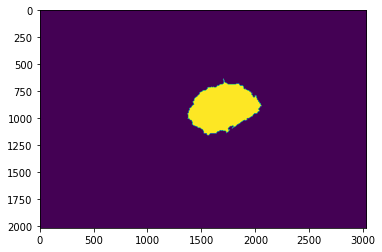

In [ ]:
plt.imshow(imseg)

In [ ]:
def rotate(outline):
    maxdiameter,pointsused,centerofimage=getdiameter(outline)
    widthoftri=abs(pointsused[0][0]-pointsused[1][0])
    heightoftri=abs(pointsused[0][1]-pointsused[1][1])
    case=0
    if widthoftri>=heightoftri:
        angle=math.asin(heightoftri/maxdiameter)
    elif widthoftri<=heightoftri:
        angle=math.asin(widthoftri/maxdiameter)
        case=1
    if case==1:
        angle=-angle
    cos=math.cos(angle)
    sin=math.sin(angle)
    newoutline=[]
    for i in outline:
        x=i[0]
        y=i[1]
        new_x=round((x*cos+y*sin)+widthoftri)
        new_y=round((-x*sin+y*cos)+heightoftri)
        newoutline.append([new_x,new_y])
    return newoutline

## Feature 2:

We have choosen to use the mean of the red spectrum of the lesion as the second feature based on some research we found online about classification of color features in skin lesions.
In their reseach they conclude amonst other features, that the mean of the red and blue channel is the best features to determine melanoma.

Link: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3184884/

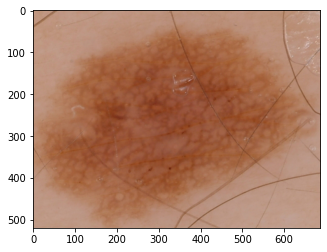

In [ ]:
plt.imshow(im)

In [ ]:

def mean_value(imagename):
    path=os.getcwd() # Getting the image to use.
    path=path[:-9]+'data/example_image/'
    path=path+str(imagename)+'.jpg'
    image=plt.imread(path)

    path=os.getcwd() # Getting the image segmentation to use.
    path=path[:-9]+'data/example_segmentation/'
    path=path+str(imagename)+'_segmentation.png'
    imseg=plt.imread(path)
    
    boolean_imseg = imseg == 1 # Masks the picture with the segmentation.

    red = image[boolean_imseg][:,0] # Masks the picture with the segmentation in the red channel.
    green = image[boolean_imseg][:,1] # Masks the picture with the segmentation in the green channel.
    blue = image[boolean_imseg][:,2] # Masks the picture with the segmentation in the blue channel.

    red_mean = np.mean(red)
    blue_mean = np.mean(blue)

    return blue_mean

print(mean_value("ISIC_0001769"))

###################################################
# Weighted RGB values.
    #rgb_list = []
    #rgb_sum = 0
    #index = 0
    #for i in im[boolean_imseg]:
    #    index = index + 1
    #    rgb = (65536 * i[0])+(256 * i[1])+i[2]
    #    rgb_list.append(rgb)
    #    rgb_sum = rgb + rgb_sum
###################################################

# fig,ax = plt.subplots(1,3,figsize=(26,8))
# ax[0].hist(red,bins=255,color='red')
# ax[0].set_title('Red')
# ax[1].hist(green,bins=255,color='green')
# ax[1].set_title("Green")
# ax[2].hist(blue,bins=255,color='blue')
# ax[2].set_title("Blue");

67.78621391561806


In [ ]:
# Color variance.
#def color_mean(im):
#    # Getting rid of all the skin
#    red=pd.DataFrame(im[:,:,0])
#    green=pd.DataFrame(im[:,:,1])
#    blue=pd.DataFrame(im[:,:,2])
#
#    maskedr=red.mask(imseg==1)
#    maskedg=green.mask(imseg==1)
#    maskedb=blue.mask(imseg==1)
#    masked = np.dstack([maskedr,maskedg,maskedb])
#    masked[1,1,:]
#
#    # Flattening the color arrays and getting them ready for histograms by getting rid of the nan values 
#    flatr=masked[:,:,0].flatten()
#    cleanr = [x for x in flatr if str(x) != 'nan']
#
#    flatg=masked[:,:,1].flatten()
#    cleang = [x for x in flatg if str(x) != 'nan']
#
#    flatb=masked[:,:,2].flatten()
#    cleanb = [x for x in flatb if str(x) != 'nan']
#
#    ###################################################
#    # Plotting the color distribution for each RGB.
#    fig,ax = plt.subplots(1,3,figsize=(26,8))
#    ax[0].hist(cleanr,bins=255,color='red')
#    ax[0].set_title('Red')
#    ax[1].hist(cleang,bins=255,color='green')
#    ax[1].set_title("Green")
#    ax[2].hist(cleanb,bins=255,color='blue')
#    ax[2].set_title("Blue");
#    ###################################################
#    
#    return None
#
#im = im
#color_mean(im)



# Task 2: Predict The Diagnosis

### Splitting data into training and test data

In [ ]:
# Training data
path=os.getcwd()#'something/somthingelse/fyp2021/notebooks'
path=path[:-9]+'data/'
path=path+'example_ground_truth.csv'
alldata=pd.read_csv(path)




# symvalues=[]
# areas=[]
# for i in trainingimagearray:
    # path=os.getcwd()
    # path=path[:-9]+'data/example_segmentation/'
    # path=path+str(i)+'_segmentation.png'
    # imseg=plt.imread(path)
    # symvalues.append(symcheck(rotateacrossdiameter(getoutline(imseg),imseg)))


In [ ]:
# path=os.getcwd()
# path=path[:-9]+'data/symvalues.csv'
# symvalues=pd.read_csv(path)
# symvalues=symvalues.drop('Unnamed: 0',axis=1)
# path=os.getcwd()
# path=path[:-9]+'features/features.csv'
# features=pd.read_csv(path)
# symvalues.columns=['image_id','symvalues']
# area=features['area'][127:149]
# peri=features['perimeter'][127:149]
# expandedfeatures=pd.concat([symvalues,area,peri],axis=1)
# path=os.getcwd()
# path=path[:-9]+'features/expandedfeatures.csv'
# expandedfeatures.to_csv(path,index=False)

In [ ]:
path=os.getcwd()#'something/somthingelse/fyp2021/notebooks'
path=path[:-9]+'data/'
path=path+'example_ground_truth.csv'
alldata=pd.read_csv(path)

path=os.getcwd()
path=path[:-9]+'features/expandedfeatures.csv'
expandedfeatures=pd.read_csv(path)

In [ ]:
# newsymvalues=[]
# for i in alldata['image_id']:
#     path=os.getcwd()
#     path=path[:-9]+'data/example_segmentation/'
#     path=path+str(i)+'_segmentation.png'
#     imseg=plt.imread(path)
#     newsymvalues.append(symcheck(rotate(getoutline(imseg))))

The vertical symmetry value for this shape is: 10498.127162525838


The vertical symmetry value for this shape is: 1671327.2101609781
The vertical symmetry value for this shape is: 3227838.194519542
The vertical symmetry value for this shape is: 237903.26590601355
The vertical symmetry value for this shape is: 210946.20477943122
The vertical symmetry value for this shape is: 2146.8470645584166
The vertical symmetry value for this shape is: 225562.69468854181
The vertical symmetry value for this shape is: 508487.68652967364
The vertical symmetry value for this shape is: 21272.921076421626
The vertical symmetry value for this shape is: 35467.00467420928
The vertical symmetry value for this shape is: 3148667.8904680377
The vertical symmetry value for this shape is: 4973087.440730061
The vertical symmetry value for this shape is: 619725.9256360922
The vertical symmetry value for this shape is: 756906.6884775497
The vertical symmetry value for this shape is: 1876113.5835589916
The vertical symmetry value for this shape is: 767585.8158721775
The vertical sym

In [ ]:
path=os.getcwd()#'something/somthingelse/fyp2021/notebooks'
path=path[:-9]+'features/'
path=path+'expandedfeatures.csv'
expandedfeatures.to_csv(path,index=False)

In [ ]:
normalizedfeatures=expandedfeatures['image_id']
counter=0
for i in expandedfeatures:
    if counter==0:
        counter+=1
        pass
    else:
        newcol=[]
        finalcol=[]
        for j in expandedfeatures[i]:
            newcol.append(j)
        newcol=pd.DataFrame(newcol)
        mean=newcol.mean()
        deviaton=newcol.std()
        for k in newcol[0]:
            finalcol.append((k-mean)/deviaton)
        finalcol=pd.DataFrame(finalcol)
        normalizedfeatures=pd.concat([normalizedfeatures,finalcol],axis=1)
normalizedfeatures.columns=expandedfeatures.columns
path=os.getcwd()
path=path[:-9]+'features/normalizedfeatures.csv'
normalizedfeatures.to_csv(path,index=False)

# Task 3: Open Question

In [ ]:
combinationsof2=[]
for i in normalizedfeatures.columns[1:]:
    for j in normalizedfeatures.columns[2:]:
        if [j,i] not in combinationsof2 and i!=j:
            combinationsof2.append([i,j])
combinationsof2

[['symsums', 'area'],
 ['symsums', 'perimeter'],
 ['symsums', 'meanblue'],
 ['symsums', 'scaledsym'],
 ['area', 'perimeter'],
 ['area', 'meanblue'],
 ['area', 'scaledsym'],
 ['perimeter', 'meanblue'],
 ['perimeter', 'scaledsym'],
 ['meanblue', 'scaledsym']]

In [ ]:
combinationsof3=[]
for i in normalizedfeatures.columns[1:]:
    for j in normalizedfeatures.columns[2:]:
        for k in normalizedfeatures.columns[3:]:
            if i!=j and j!=k and i!=k and [j,i,k] not in combinationsof3 and [j,k,i] not in combinationsof3 and [k,j,i] not in combinationsof3 and [k,i,j] not in combinationsof3 and [i,k,j] not in combinationsof3:
                combinationsof3.append([i,j,k])


In [ ]:
for i in combinationsof2:
    neigh=knn(n_neighbors=5)
    X_train, X_test, y_train, y_test = train_test_split(normalizedfeatures[i],alldata['melanoma'],train_size=0.70)
    neigh.fit(X_train,y_train)
    yval=neigh.predict(X_test)
    acc=accuracy_score(y_test,yval)
    tp=0
    fn=0
    fp=0
    tn=0
    for j,k in zip(y_test,yval):
        if j==k and j==1:
            tp+=1
        if j==1 and k==0:
            fn+=1
        if j==k and j==0:
            tn+=1
        if j==0 and k==1:
            fp+=1
    sensitivity=tp/(tp+fn)
    specificity=tn/(tn+fp)

    auc = roc_auc_score(y_test,yval)
    print('The combination of these:',i,'had an accuracy score of:',acc)
    print('The sensitivity of this combination is:',sensitivity)
    print('The specificity of this model is:',specificity)
    print('The auc value is:',auc,'\n')

The combination of these: ['symsums', 'area'] had an accuracy score of: 0.7777777777777778
The sensitivity of this combination is: 0.25
The specificity of this model is: 0.8918918918918919
The auc value is: 0.5709459459459459 

The combination of these: ['symsums', 'perimeter'] had an accuracy score of: 0.8222222222222222
The sensitivity of this combination is: 0.1111111111111111
The specificity of this model is: 1.0
The auc value is: 0.5555555555555556 

The combination of these: ['symsums', 'meanblue'] had an accuracy score of: 0.8222222222222222
The sensitivity of this combination is: 0.0
The specificity of this model is: 0.9487179487179487
The auc value is: 0.47435897435897434 

The combination of these: ['symsums', 'scaledsym'] had an accuracy score of: 0.7333333333333333
The sensitivity of this combination is: 0.1
The specificity of this model is: 0.9142857142857143
The auc value is: 0.5071428571428572 

The combination of these: ['area', 'perimeter'] had an accuracy score of: 0.

In [ ]:
for i in combinationsof3:
    neigh=knn()
    X_train, X_test, y_train, y_test = train_test_split(normalizedfeatures[i],alldata['melanoma'],train_size=0.70)
    neigh.fit(X_train,y_train)
    yval=neigh.predict(X_test)
    acc=accuracy_score(y_test,yval)
    auc = roc_auc_score(y_test,yval)
    tp=0
    fn=0
    fp=0
    tn=0
    for j,k in zip(y_test,yval):
        if j==k and j==1:
            tp+=1
        if j==1 and k==0:
            fn+=1
        if j==k and j==0:
            tn+=1
        if j==0 and k==1:
            fp+=1
    sensitivity=tp/(tp+fn)
    specificity=tn/(tn+fp)

    auc = roc_auc_score(y_test,yval)
    print('The combination of these:',i,'had an accuracy score of:',acc)
    print('The sensitivity of this combination is:',sensitivity)
    print('The specificity of this model is:',specificity)
    print('The auc value is:',auc,'\n')




The combination of these: ['symsums', 'area', 'perimeter'] had an accuracy score of: 0.8222222222222222
The sensitivity of this combination is: 0.0
The specificity of this model is: 0.9487179487179487
The auc value is: 0.47435897435897434 

The combination of these: ['symsums', 'area', 'meanblue'] had an accuracy score of: 0.7777777777777778
The sensitivity of this combination is: 0.16666666666666666
The specificity of this model is: 1.0
The auc value is: 0.5833333333333334 

The combination of these: ['symsums', 'area', 'scaledsym'] had an accuracy score of: 0.8
The sensitivity of this combination is: 0.14285714285714285
The specificity of this model is: 0.9210526315789473
The auc value is: 0.5319548872180451 

The combination of these: ['symsums', 'perimeter', 'meanblue'] had an accuracy score of: 0.8222222222222222
The sensitivity of this combination is: 0.125
The specificity of this model is: 0.972972972972973
The auc value is: 0.5489864864864865 

The combination of these: ['symsu

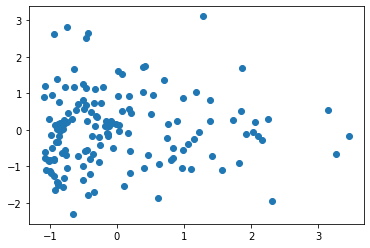

In [ ]:
plt.scatter(normalizedfeatures['scaledsym'],normalizedfeatures['meanblue'])

In [ ]:
normalizedfeatures['symvalues']

0     -0.232179
1     -0.232237
2     -0.232225
3     -0.232190
4     -0.232180
         ...   
133    1.093391
134    3.815991
135    6.180997
136    0.107747
137    1.600830
Name: symvalues, Length: 138, dtype: float64

In [ ]:
yval

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
y_test 

18     0.0
8      0.0
20     0.0
85     1.0
6      0.0
43     0.0
75     1.0
107    1.0
7      0.0
24     0.0
92     0.0
101    0.0
130    1.0
2      0.0
70     0.0
102    1.0
53     0.0
16     0.0
12     0.0
133    1.0
105    0.0
74     0.0
52     0.0
69     0.0
122    0.0
39     0.0
76     1.0
48     0.0
54     0.0
86     1.0
19     0.0
66     0.0
135    0.0
126    0.0
21     0.0
100    0.0
65     0.0
116    0.0
27     0.0
123    1.0
36     0.0
34     0.0
Name: melanoma, dtype: float64

In [ ]:
#adding noise
noise = np.random.RandomState(72465).uniform(0, 0.1, size=(normalizedfeatures.shape[0], 20))
X = np.hstack((normalizedfeatures[['symvalues','area', 'perimeter','meanred','meanblue']], noise))
Y=alldata['melanoma']

In [ ]:
X_dev, X_test, y_dev, y_test = train_test_split(
        X, Y, stratify=Y, random_state=89211)
X_train, X_val, y_train, y_val = train_test_split(
        X_dev, y_dev, stratify=y_dev)

<BarContainer object of 25 artists>

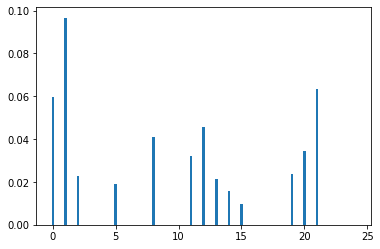

In [ ]:
selector = SelectKBest(mutual_info_classif, k=2)
selector.fit(X_train, y_train)

scores = selector.scores_

plt.bar(np.arange(0,25), scores, width=.2,
        label=r'Feature score')

In [ ]:
scores

array([0.05978018, 0.09667058, 0.0230096 , 0.        , 0.        ,
       0.01926122, 0.        , 0.        , 0.0409272 , 0.        ,
       0.        , 0.03206689, 0.04571784, 0.02159254, 0.01592849,
       0.00971149, 0.        , 0.        , 0.        , 0.02361009,
       0.03443235, 0.06349328, 0.        , 0.        , 0.        ])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c01f5965-259c-4c17-ae6d-879577586d70' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>